# **1. Introduction**

In this notebook, we implement and train three different types of classifiers to predict the similarity score between pairs of sentences based on the extracted features.

We will identify the best model and compare our results with various alternatives, including classifiers using only lexical features, only syntactic features, or a combination of both. Additionally, we will compare our results against the official benchmarks.

We will also perform a feature importance analysis to determine which features are most influential in assessing the similarity between sentences. Furthermore, we will analyze the role and significance of lexical and semantic features to assess whether one type of feature is more effective than the other in determining if a pair of sentences are paraphrases.

In [ ]:
# Install the necessary libraries
%pip install pandas numpy scikit-learn matplotlib scipy joblib

In [89]:
# Import the required libraries
import pandas as pd
import joblib

import numpy as np
from sklearn.preprocessing import PowerTransformer

from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from scipy.stats import pearsonr

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

import matplotlib.cm as cm

# Custom scorer using Pearson correlation
def pearson_corr(y_true, y_pred):
    return pearsonr(y_true, y_pred)[0]

pearson_scorer = make_scorer(pearson_corr, greater_is_better=True)

First, we load the preprocessed training and test datasets, as well as the extracted features for both the training and test datasets.

In [90]:
# Load Training and Test Datasets
train_data = pd.read_csv('datasets/train_preprocessed.csv')
test_data  = pd.read_csv('datasets/test_preprocessed.csv')

# Load Training and Test Features
features_train = pd.read_csv('features/features_train.csv')
features_test  = pd.read_csv('features/features_test.csv')

As observed in the previous notebook in the Feature Visualization section, some of our features do not follow a gaussian distribution. Therefore, we decided to apply Yeo-Johnson transformations to modify the distribution of these features, enhancing their ability to provide more relevant information.

In [91]:
# Initialize Yeo-Johnson power transformer
power_transformer = PowerTransformer(method='yeo-johnson')

# List of columns to apply log1p transformation
log_transform_cols = [
    "longest_common_substring", "longest_common_subsequence",
    "greedy_string_tiling", "3_gram_word_Jaccard",
    "4_gram_word_Jaccard", "2_gram_word_Jaccard_without_SW",
    "pathlen_similarity", "lin_similarity", "weighted_word_overlap"
]

# Apply log1p transformation to specified training features
for col in log_transform_cols:
    features_train[col] = np.log1p(features_train[col])

# Apply Yeo-Johnson transformation to selected training features
features_train[["2_gram_char", "lexical_substitution_system", "wordnet_augmented_overlap", "wordnet_augmented_word_overlap"]] = power_transformer.fit_transform(features_train[["2_gram_char", "lexical_substitution_system", "wordnet_augmented_overlap", "wordnet_augmented_word_overlap"]])

# Apply log1p transformation to specified test features
for col in log_transform_cols:
    features_test[col] = np.log1p(features_test[col])

# Apply the Yeo-Johnson transformation to selected test features
features_test[["2_gram_char", "lexical_substitution_system", "wordnet_augmented_overlap", "wordnet_augmented_word_overlap"]] = power_transformer.transform(features_test[["2_gram_char", "lexical_substitution_system", "wordnet_augmented_overlap", "wordnet_augmented_word_overlap"]])

# **2. Model Training**

In this section, we train three different models and perform hyperparameter tuning using grid search for each of them.

We decided to shuffle the training features to eliminate any spatial bias. Currently, the features are sorted by dataset, with consecutive entries corresponding to the same dataset. Since we train our models using cross-validation, some folds may contain features from only a single dataset, potentially causing the model to become biased or overfitted to that dataset. To prevent this, we randomly shuffle the features, thereby avoiding such issues and enhancing the training process of our models.

In [92]:
features_train_shuffled, score_shuffled = shuffle(features_train, train_data["score"], random_state=42)

## 2.1. Linear Regression

The first model we implemented is the Linear Regression model. We selected this model because it was used in the UKP paper [1]. We followed the same process as described in the paper, utilizing 10-fold cross-validation.

In [62]:
# Linear Regression model
linear_model = LinearRegression()

# Perform 10-fold cross-validation
linear_scores = cross_val_score(linear_model, features_train_shuffled, score_shuffled, cv=10, scoring=pearson_scorer)

print("Linear Regression - Pearson Correlation Scores:", linear_scores)
print("Linear Regression - Mean Pearson Correlation:", linear_scores.mean())

Linear Regression - Pearson Correlation Scores: [0.81179901 0.81167043 0.8233549  0.88362347 0.80545697 0.85537709
 0.7969279  0.82632593 0.86051435 0.86779703]
Linear Regression - Mean Pearson Correlation: 0.8342847063515147


In [63]:
# Save the Linear Regression model
linear_model_path = 'models/lr_best_model.joblib'
joblib.dump(linear_model, linear_model_path)
print(f"Linear Regression model saved to {linear_model_path}")

Linear Regression model saved to models/lr_best_model.joblib


## 2.2. Random Forest Regressor

The second model we implemented is the Random Forest Regressor. We selected this model based on our judgment and the generally strong performance of tree-based models in this type of task.

In [64]:
# Hyperparameter Grid for Random Forest
rf_params = {
    "n_estimators": [100, 200, 400],
    "max_depth": [15, 20, 25],
    "min_samples_split": [2, 5]
}

# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=0)

# Grid Search for Random Forest
rf_grid = GridSearchCV(rf_model, rf_params, cv=10, scoring=pearson_scorer, n_jobs=-1)
rf_grid.fit(features_train_shuffled, score_shuffled)

# Best Model and Parameters
rf_best_model = rf_grid.best_estimator_
rf_best_params = rf_grid.best_params_

# Cross-validation with the Best Model
rf_best_scores = cross_val_score(rf_best_model, features_train_shuffled, score_shuffled, cv=10, scoring=pearson_scorer)

print("Random Forest - Best Parameters:", rf_best_params)
print("Random Forest - Pearson Correlation Scores:", rf_best_scores)
print("Random Forest - Mean Pearson Correlation:", rf_best_scores.mean())

Random Forest - Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 400}
Random Forest - Pearson Correlation Scores: [0.83550534 0.83799488 0.85428418 0.89237153 0.81889181 0.8786213
 0.83684206 0.84270835 0.89558081 0.88910407]
Random Forest - Mean Pearson Correlation: 0.8581904332253126


In [65]:
# Save the Best Random Forest model
rf_model_path = 'models/rf_best_model.joblib'
joblib.dump(rf_best_model, rf_model_path)
print(f"Best Random Forest model saved to {rf_model_path}")

Best Random Forest model saved to models/rf_best_model.joblib


## 2.3. Gradient Boosting

The third model we implemented is a Gradient Boosting Regressor. Gradient Boosting models are widely used for regression tasks, and we anticipated that this type of model could yield strong performance for our project.

In [66]:
# Hyperparameter Grid for Gradient Boosting
gb_params = {
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [5, 10, 15, 20],
    "min_samples_split": [2, 5, 7],
    "subsample": [0.5, 1.0]
}

# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=0)

# Grid Search for Gradient Boosting
gb_grid = GridSearchCV(gb_model, gb_params, cv=10, scoring=pearson_scorer, n_jobs=-1)
gb_grid.fit(features_train_shuffled, score_shuffled)

# Best Model and Parameters
gb_best_model = gb_grid.best_estimator_
gb_best_params = gb_grid.best_params_

# Cross-validation with the Best Model
gb_best_scores = cross_val_score(gb_best_model, features_train_shuffled, score_shuffled, cv=10, scoring=pearson_scorer)

print("Gradient Boosting - Best Parameters:", gb_best_params)
print("Gradient Boosting - Pearson Correlation Scores:", gb_best_scores)
print("Gradient Boosting - Mean Pearson Correlation:", gb_best_scores.mean())

Gradient Boosting - Best Parameters: {'learning_rate': 0.01, 'max_depth': 10, 'min_samples_split': 7, 'n_estimators': 400, 'subsample': 0.5}
Gradient Boosting - Pearson Correlation Scores: [0.8363408  0.8338872  0.86044719 0.89789973 0.83945276 0.88407335
 0.84448319 0.84980388 0.89333276 0.89030064]
Gradient Boosting - Mean Pearson Correlation: 0.8630021492551716


In [67]:
# Save the Best Gradient Boosting model
gb_model_path = 'models/gb_best_model.joblib'
joblib.dump(gb_best_model, gb_model_path)
print(f"Best Gradient Boosting model saved to {gb_model_path}")

Best Gradient Boosting model saved to models/gb_best_model.joblib


## **3. Model Selection**

After training all three models, we select the one that achieved the highest average Pearson correlation.

In [68]:
# Summarize the mean Pearson correlation scores for each model
models_summary = {
    "Linear Regression": {"Mean Pearson CV Score": linear_scores.mean()},
    "Random Forest": {"Mean Pearson CV Score": rf_best_scores.mean()},
    "Gradient Boosting": {"Mean Pearson CV Score": gb_best_scores.mean()},
}

# DataFrame for better visualization
models_df = pd.DataFrame(models_summary).T
print(models_df)

# Identify the best model based on the highest mean Pearson correlation
best_model_name = models_df["Mean Pearson CV Score"].idxmax()
best_model_score = models_df["Mean Pearson CV Score"].max()

print(f"Best Model: {best_model_name} with a Mean Pearson CV Score of {best_model_score}")

                   Mean Pearson CV Score
Linear Regression               0.834285
Random Forest                   0.858190
Gradient Boosting               0.863002
Best Model: Gradient Boosting with a Mean Pearson CV Score of 0.8630021492551716


In [69]:
# Select the Best Model
if best_model_name == "Linear Regression":
    model = linear_model
elif best_model_name == "Random Forest":
    model = rf_best_model
elif best_model_name == "Gradient Boosting":
    model = gb_best_model

In [70]:
# Path to the Best Model
best_model_path = 'models/best_model.joblib'

# Save the Best Model
joblib.dump(model, best_model_path)
print(f"Best model saved to {best_model_path}")

Best model saved to models/best_model.joblib


In [93]:
# Path to the Best Model
best_model_path = 'models/best_model.joblib'

# Load the Best Model
model = joblib.load(best_model_path)
print(f"Best model loaded from {best_model_path}")

Best model loaded from models/best_model.joblib


# **4. Test Set Evaluation**

After selecting the optimal model, we evaluate its performance on the test set.

In [94]:
# Actual scores from the test set
y_true = test_data["score"]

# Predict scores using the selected model
y_pred = model.predict(features_test)

# Pearson correlation between actual and predicted scores
pearson_corr = pearsonr(y_true, y_pred)[0]
print("Pearson Correlation:", pearson_corr)

Pearson Correlation: 0.7575784829418253


We obtained a Pearson Correlation of 0.7576 on the test data. This indicates a strong positive relationship between the actual and predicted similarity scores, suggesting that our model effectively captures the underlying patterns in the data.

# **5. Analysis with different texts**

**A continuación vamos a analizar la performance de nuestro mejor modelo según cada dataset. Con esto esperamos sacar información útil sobre cómo se comporta nuestro modelo con pares de frases de diferentes "proveniencias?", como por ejemplo pares de frases obtenidas de news sources on the web (MSRpar), manual description of videos (MSRvid), etc.** y ver si nuestro modelo funciona mejor en algunos casos que en otros.

In [95]:
pearson_results = {}

for dataset_name, group in test_data.groupby("dataset_name"):
    y_true = group["score"]

    features_group = features_test.loc[group.index].copy()
    
    y_pred = model.predict(features_group)

    pearson_corr = pearsonr(y_true, y_pred)[0]

    pearson_results[dataset_name] = pearson_corr

    print(f"Dataset: {dataset_name}, Pearson Correlation: {pearson_corr}")

Dataset: MSRpar, Pearson Correlation: 0.6097693001022645
Dataset: MSRvid, Pearson Correlation: 0.8386748282534271
Dataset: SMTeuroparl, Pearson Correlation: 0.4588782601632434
Dataset: surprise.OnWN, Pearson Correlation: 0.7066395838074657
Dataset: surprise.SMTnews, Pearson Correlation: 0.439522571834905


En la anterior gráfica podemos observar la performance de nuestro mejor modelo con los 5 diferentes datasets en el test set. Obtenemos una gran pearson correlation de 0.8386 en MSRvid, seguido de una buena performance en el dataset de OnWN con una pearson correlation de 0.7066. el siguiente modelo ya performa regular con una pearson correlation de 0.609; i los dos últimos modelos, SMTeuroparl i SMTnews, obtienen pearson correlations muy bajas de 0.4588 i 0.439, respectivametne.

Si analizamos concretamente qué tipo de frases se encuentran en cada dataset, obtenemos las siguientes descripciones. También mostramos la mean pearson correlation obtenida de todos los participantes en la SemEval-2012 Task 6 para cada dataset:

- MSRpar: Sentences collected from news resources on the web. The mean pearson correlation for this dataset is 0.73.
- MSRvid: Sentences describing actions of events in brief videos done by annotaters (note, the annotators provided the description, not the video, just to be clear, don't include this in the final text, just so you can write it clearly). The mean pearson correlation for this dataset is 0.88.
- SMTeuroparl: Translations from French to English sentences from the Workshops on Statistical Machine Translation (WMT). The mean pearson correlation for this dataset is 0.57.
- OnWN: Glosses from OntoNotes and WordNet, which are large-scale linguistic resources for natural language processing.The mean pearson correlation for this dataset is 0.73.
- SMTnews: Sentences of translations from French to English  from news conversations. The mean pearson correlation for this dataset is 0.61.

Con las pearson correlations obtenidas, la descsripcionde cada dataset y la average pearson correlation en la competicion, podemos sacar las siguientes conclusiones.

Primero, el dataset MSRvid obtiene la mayor pearson correlation con nuestro mejor modelo (0.838) y también con el average de la competicion (0.88), aunque nuestra pearson es un poco mas bajo que el average. Nuestro segundo dataset que mas perason hemos obtenido es OnWN con 0.706, el cual tambien coincide el average en la competicion que ha quedado segundo empetado con MSRpar una pearson de 0.73, otra vez obteniendo un poco menos de pearson que el average. El tercer dataset, MSRpar, hemos obtenido una pearson mucho menor que la average de la competicion con 0.61, 0.12 menos. Para el cuarto y quinto datasets, SMTeuroparl y SMTnews, obtenido tambien una gran mayor diferencia de pearsons con la average competition pearson, con 0.12 y 0.17 respectivamente.

Aunque hayamos obtenido una buena average pearson correlation de 0.757, nuestro modelo ha rendido muy por debajo en los datasets de SMT y MSRpar, y un poco por debajo con MSRvid y OnWN. Analizando el contenido de las frases, observamos una tendencia nuestra y en la competicion de ser mas dificil classificar la similaridad entre frases cuando son traducciones de un idioma a otro, en este caso del frances al ingles. para frases muy dichas en el dia a dia, como frases que se dicen en las noticias en MSRpar o que forman parte de un gloss de NLP en OnWN, los modelos en general suelen rendir mejor.

# **6. Comparison with Official Results**

To contextualize our results, we compare them against the top 10 results from the SemEval-2012 Task 6 competition and the baseline model.

In [ ]:
# Load Official Results from SemEval-2012 Task 6
official_results = pd.read_csv('results/official_results.csv')

In [101]:
y_true = test_data["score"]
y_pred = model.predict(features_test)
pearson_corr = pearsonr(y_true, y_pred)[0]

# Normalize predictions using linear transformation
all_gold_scores = np.array(y_true)
all_predictions = np.array(y_pred)

beta_1, beta_2 = np.polyfit(all_predictions, all_gold_scores, 1)
normalized_predictions = all_predictions * beta_1 + beta_2

# Calculate normalized Pearson correlation
normalized_pearson_corr, _ = pearsonr(normalized_predictions, all_gold_scores)

# Calculate weighted mean of Pearson
dataset_sizes = [len(test_data[test_data["dataset_name"] == d]) for d in pearson_results]
all_mean = sum([r * n for r, n in zip(pearson_results.values(), dataset_sizes)]) / sum(dataset_sizes)

best_results = {
    "ALL": pearson_corr,
    "ALL_nrm": normalized_pearson_corr,
    "Mean": all_mean,
    "MSRpar": pearson_results["MSRpar"],
    "MSRvid": pearson_results["MSRvid"],
    "SMT-eur": pearson_results["SMTeuroparl"],
    "On-WN": pearson_results["surprise.OnWN"],
    "SMT-news": pearson_results["surprise.SMTnews"]
}

best_results

{'ALL': 0.7575784829418253,
 'ALL_nrm': 0.7575784829418254,
 'Mean': 0.6442430539573436,
 'MSRpar': 0.6097693001022645,
 'MSRvid': 0.8386748282534271,
 'SMT-eur': 0.4588782601632434,
 'On-WN': 0.7066395838074657,
 'SMT-news': 0.439522571834905}

In [ ]:

# Add our results to the official results DataFrame
comparison_results = pd.concat([official_results, own_results], ignore_index=True)

# Modify Official Results
#official_results.insert

# Display the comparison
print(comparison_results)

# **7. Feature Importance Analysis**

We believe it is important to identify which features are most influential in the final model for classifying each pair of sentences. Below, we present a bar chart displaying each feature sorted by their importance.

In [72]:
# Extract the importance from each feature
importances = model.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({
    'Feature': features_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


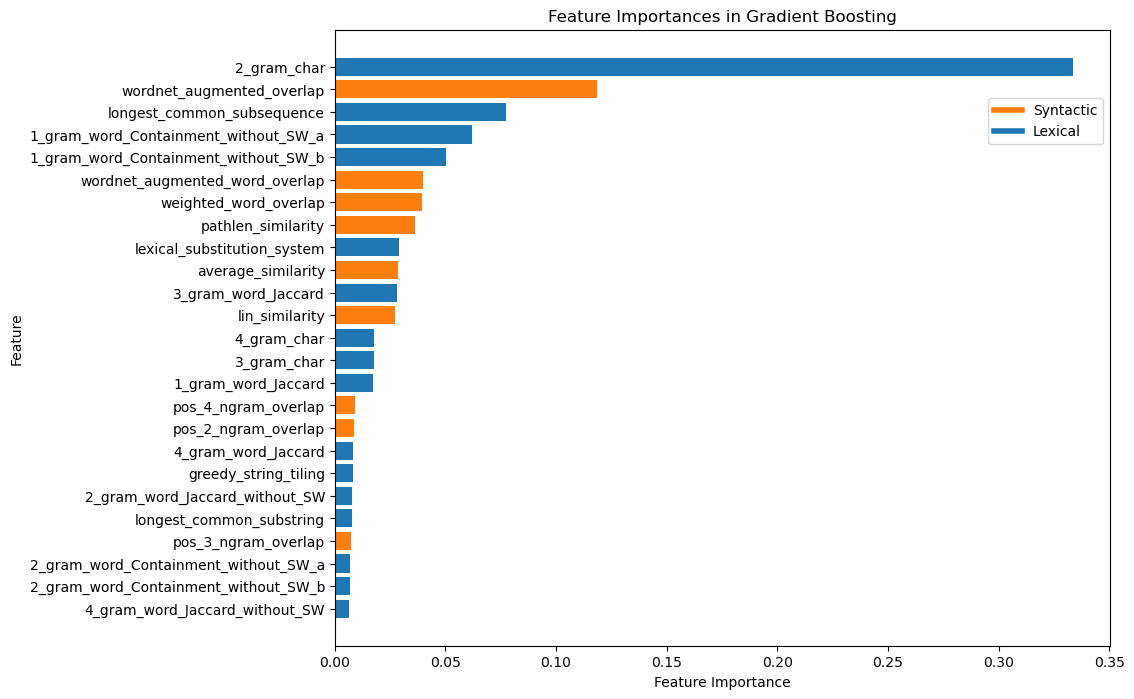

In [88]:
# Define Syntactic Features
syntactic_features = ['pathlen_similarity', 'lin_similarity', 'average_similarity', 'wordnet_augmented_word_overlap', 'wordnet_augmented_overlap',
                      'weighted_word_overlap', 'pos_2_ngram_overlap', 'pos_3_ngram_overlap', 'pos_4_ngram_overlap']

# Assign colours based on feature type
feature_colors = [cm.tab10.colors[1] if feature in syntactic_features else cm.tab10.colors[0] 
                  for feature in feature_importances['Feature']]

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color=feature_colors)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title(f'Feature Importances in {best_model_name}')
plt.gca().invert_yaxis() # Most important feature at the top

# Create a legend
plt.legend(handles=[
    plt.Line2D([0], [0], color=cm.tab10.colors[1], lw=4, label='Syntactic'),
    plt.Line2D([0], [0], color=cm.tab10.colors[0], lw=4, label='Lexical')
], loc='upper right', bbox_to_anchor=(1, 0.9))

plt.show()

The bar chart displays the importance of each feature in the selected model. Features with higher importance scores contribute more significantly to the model's predictions, while those with lower scores have less influence.

From the chart, we observe that certain features, such as `2_gram_char` and `wordnet_augmented_overlap` have high importance, indicating they are crucial in determining sentence similarity. These features capture essential aspects of lexical and semantic similarity effectively. On the other hand, features like `4_gram_word_Jaccard_without_SW` and `pos_3_ngram_overlap` show lower importance, suggesting they have a minimal impact on the model's decisions.

**`2_gram_chart` es la feature que tiene más importancia por diferencia, posiblemente indicando que features léxicas funcionan muy bien para estos datasets. Después de esta feature, el equilibrio entre features lexicas y sintacticas está muy balanceado, siguiendo una feature sintáctica `wordnet_augmented_overlap`, seguido de 3 features léxicas y luego 3 features sintácticas. En el siguiente grafo, vamos a mostrar la feature importance de nuestro mejor modelo dependiendo del dataset.**

aqui fer feature analysis però amb importancia acumulada donada el tipus de feature (lexica o semantica) amb un bar plot en horitzontal

Overall, the analysis reveals that lexical features tend to be more influential than syntactic features in assessing sentence similarity.

# **Conclusions**

In this project, we successfully implemented and trained three different classifiers to predict the similarity between pairs of sentences.

# **References**